# Hacemos un seguidor de línea usando la cámara del robot y lógica difusa

Esta vez, haremos un seguidor de línea usando la cámara del robot. Para hacer esto, usaremos la cámara para capturar imágenes del suelo y procesarlas para detectar la línea. Luego usaremos la información obtenida para controlar el robot y hacer que siga la línea.

Para hacer esto, usaremos la librería `opencv` para procesar las imágenes, `Aitk.Robots` para el simulador, y la librería de lógica difusa `scikit-fuzzy` para decidir cómo controlar el robot.

Comencemos por instalar e importar las librerías necesarias:

In [1]:
%pip install aitk numpy opencv-python-headless matplotlib requests Pillow==9.4 scikit-fuzzy==0.4.2 #La libreria 0.5 es más reciente pero tiene problemas con el ControlSystem.view()

In [2]:
import aitk.robots as bots
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skfuzzy as fuzz
import skfuzzy.control as ctrl

## Seguidor de línea simple

Crearemos el mundo de Robot y el Robot. Necesitaremos la imagen `EX2_pista_5.png` para este ejemplo, contiene una pista con una línea negra.

El robot tendrá una cámara que capturará imágenes del suelo y las procesará para detectar la línea. Será de tipo `GroundCamera` i la añadiremos al robot.

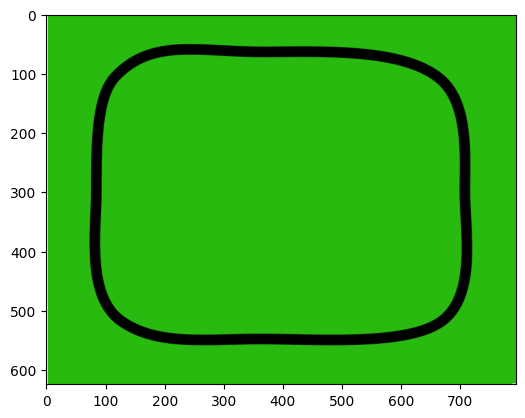

In [3]:
nom_imatge = "EX2_pista_5.png"

# Cargamos la imagen

img = cv2.imread(nom_imatge)

# Mostramos la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

amplada_camera = 120
alcada_camera = 50
robot = bots.Scribbler(x=24, y=80, a=90)
robot.add_device(bots.GroundCamera(width=amplada_camera, height=alcada_camera))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 2509511


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

Implementa la función `controlador_cam` que será el que tendrá que controlar el robot. Puedes basarte en el ejemplo hecho en [`1.-Introduccio_OpenCV_ES.ipynb`](https://colab.research.google.com/github/martinezpenya/MIA-IABD-2425/blob/main/UD04/notebooks/1.-Introduccio_OpenCV_ES.ipynb) para detectar la línea (ten en cuenta que la cámara aquí está debajo del robot, por lo que si usamos la parte inferior de la imagen seguramente el robot sea demasiado inestable, sería mejor usar la parte superior de la imagen) y en el ejemplo hecho en [`3.-exemples_robots_ES.ipynb`](https://colab.research.google.com/github/martinezpenya/MIA-IABD-2425/blob/main/UD04/notebooks/3.-exemples_robots_ES.ipynb) para controlar el robot.

Para simplificar, utilizaremos la lógica difusa para decidir cómo controlar el robot. Como variable de entrada, utilizaremos el error de la posición de línea con respecto al centro de la imagen (que irá de -ANCHO_CAMARA//2 a +ANCHO_CAMARA//2) y como variables de salida, la velocidad y dirección del robot (que variará de -1 a 1).

Recuerda, el operador `//` calcula la división entera.

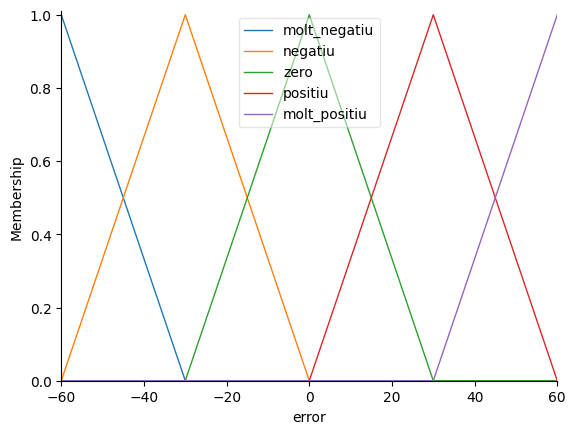

In [30]:
# Definimos la variable de entrada
error = ctrl.Antecedent(np.arange(-60, 61, 1), "error")
# ...

# Definimos las funciones de pertenencia
error['molt_negatiu'] = fuzz.trimf(error.universe, [-60, -60, -30])
error['negatiu'] = fuzz.trimf(error.universe, [-60, -30, 0])
error['zero'] = fuzz.trimf(error.universe, [-30, 0, 30])
error['positiu'] = fuzz.trimf(error.universe, [0, 30, 60])
error['molt_positiu'] = fuzz.trimf(error.universe, [30, 60, 60])

# ...

error.view()

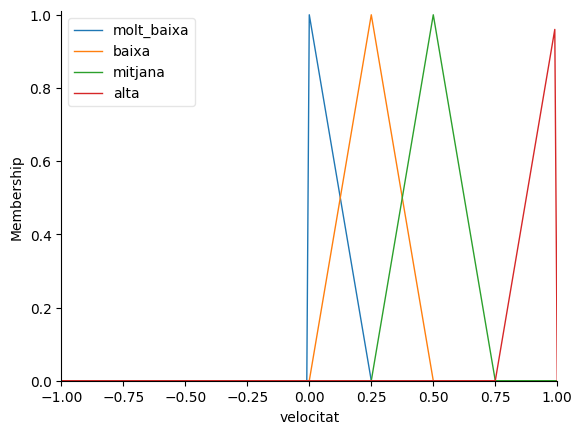

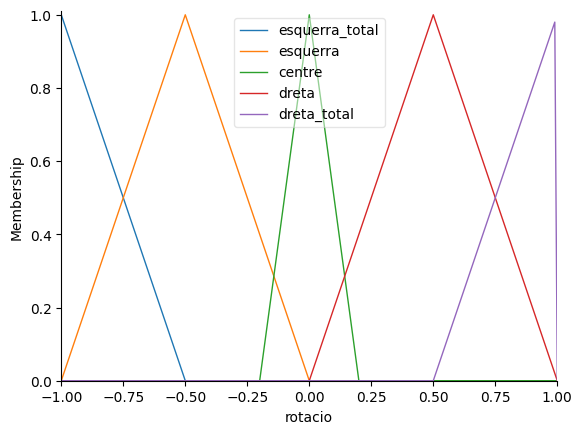

In [39]:
# Definimos variables de salida
# Definir la velocidad de salida
velocitat = ctrl.Consequent(np.arange(-1, 1.01, 0.01), 'velocitat')

velocitat['molt_baixa'] = fuzz.trimf(velocitat.universe, [0, 0, 0.25])
velocitat['baixa'] = fuzz.trimf(velocitat.universe, [0, 0.25,0.50])
velocitat['mitjana'] = fuzz.trimf(velocitat.universe, [0.25, 0.5, 0.75])
velocitat['alta'] = fuzz.trimf(velocitat.universe,[0.75, 1, 1])


# Definir la rotación de salida
rotacio = ctrl.Consequent(np.arange(-1, 1.01, 0.01), 'rotacio')

rotacio['esquerra_total'] = fuzz.trimf(rotacio.universe, [-1, -1, -0.5])
rotacio['esquerra'] = fuzz.trimf(rotacio.universe, [-1, -0.5, 0])
rotacio['centre'] = fuzz.trimf(rotacio.universe, [-0.2, 0, 0.2])
rotacio['dreta'] = fuzz.trimf(rotacio.universe, [0, 0.5, 1])
rotacio['dreta_total'] = fuzz.trimf(rotacio.universe, [0.5, 1, 1])

# ...


velocitat.view()
rotacio.view()

0.25


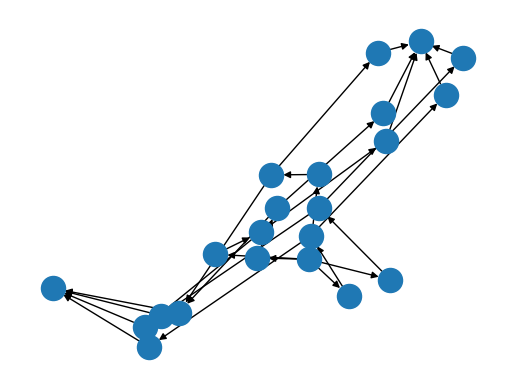

In [40]:
# Definimos las reglas
regla1 = ctrl.Rule(error['molt_negatiu'], (velocitat['molt_baixa'], rotacio['esquerra_total']))
regla2 = ctrl.Rule(error['negatiu'], (velocitat['baixa'], rotacio['esquerra']))
regla3 = ctrl.Rule(error['zero'], (velocitat['alta'], rotacio['centre']))
regla4 = ctrl.Rule(error['positiu'], (velocitat['baixa'], rotacio['dreta']))
regla5 = ctrl.Rule(error['molt_positiu'], (velocitat['molt_baixa'], rotacio['dreta_total']))

# Crear el sistema de control difuso

# Definimos el sistema de control
control = ctrl.ControlSystem([regla1, regla2, regla3, regla4, regla5])
# Simulamos el sistema de control
simulacion = ctrl.ControlSystemSimulation(control)

simulacion.input['error'] = 30
simulacion.compute()
print(simulacion.output['velocitat'])
# print(simulacion.output['rotacio'])

control.view()

  0%|          | 0/600 [00:00<?, ?it/s]

33
34
34
-34
-33
-33
-33
-32
-33
-34
34
33
32
31
32
32
32
33
-34
-33
-33
-32
-32
-32
-32
-32
-34
33
32
31
30
29
29
29
30
30
31
33
-34
-33
-31
-30
-30
-29
-29
-29
-30
-32
-33
-34
33
32
30
29
28
28
28
29
29
31
32
34
-33
-32
-30
-29
-28
-27
-27
-27
-28
-29
-30
-31
-33
34
33
32
31
30
30
30
31
32
33
-34
-33
-31
-30
-29
-29
-28
-29
-29
-30
-32
-33
34
33
32
31
30
31
31
32
33
34
-33
-32
-30
-29
-28
-28
-27
-27
-28
-29
-31
-32
-33
34
33
31
31
30
30
30
31
32
33
35
-33
-31
-30
-28
-28
-27
-27
-26
-27
-26
-25
-26
-28
-30
-32
32
30
29
28
27
27
27
27
28
29
30
32
-33
-30
-28
-28
-25
-24
-24
-23
-23
-24
-26
-28
-31
32
30
29
28
27
26
27
27
28
29
31
32
-31
-29
-28
-26
-25
-24
-23
-23
-23
-25
-27
-30
33
31
30
29
28
28
28
28
30
30
32
-32
-30
-28
-26
-25
-25
-24
-24
-25
-27
-30
33
32
31
29
29
29
28
29
29
31
32
-32
-30
-28
-27
-25
-24
-24
-24
-25
-28
-30
33
31
30
29
29
28
28
28
29
30
32
33
-31
-28
-27
-25
-23
-22
-21
-21
-21
-23
-25
-27
-32
33
31
30
29
28
27
27
27
28
29
31
33
-32
-29
-28
-26
-25
-24
-24
-24

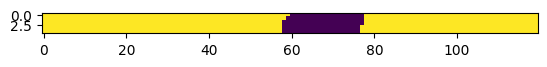

In [35]:

def controlador_cam(robot):
    cam = robot['ground-camera']
    image = cam.get_image()

     # Convirtemos la imagen en una matriz numpy para trabajar en OpenCV
    image = np.array(image)

    # convertir a escala de grises
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray)

    # Nos quedamos con la parte superior de la imagen
    img_top = img_gray[0:5,:]
    plt.imshow(img_top)

    # Aplicamos un filtro de desenfoque gaussiano
    img_blurred = cv2.GaussianBlur(img_top, (3, 3), 0)
    plt.imshow(img_blurred)

    # Binarizamos la imagen (treshold)
    ret, img_thresh = cv2.threshold(img_blurred, 110, 255, cv2.THRESH_BINARY)
    plt.imshow(img_thresh)

    # Buscamos los contornos
    img_thresh_copy = img_thresh.copy()
    contours, _ = cv2.findContours(img_thresh_copy, 1, cv2.CHAIN_APPROX_NONE)

    # Dibujamos los contornos

    # Ingresamos el error al sistema de control

    if len(contours) != 0:
        # Centro de la imagen
        center_x = img_gray.shape[1] // 2
        center_y = img_gray.shape[0] // 2

        # Inicializar la mejor distancia y el mejor contorno
        best_contour = None
        min_distance = float('inf')

        for contour in contours:
            # Calcular el centroide del contorno
            center = cv2.moments(contour)
            if center['m00'] == 0:
                continue  # Evitar división por cero
            cx = int(center['m10'] / center['m00'])
            cy = int(center['m01'] / center['m00'])

            # Calcular la distancia al centro de la imagen
            distance = np.sqrt((cx - center_x) ** 2 + (cy - center_y) ** 2)

            # Seleccionar el contorno más cercano
            if distance < min_distance:
                min_distance = distance
                best_contour = contour

        # Si encontramos un contorno cercano
        if best_contour is not None:
            center = cv2.moments(best_contour)
            cx = int(center['m10'] / center['m00'])
            cy = int(center['m01'] / center['m00'])

            # Calcular el error (distancia al centro de la imagen)
            error = cx - center_x
            print(error)
            simulacion.input['error'] = error
            simulacion.compute()

            # Obtener la velocidad y rotación
            velocidad = simulacion.output['velocitat']
            rotacion = simulacion.output['rotacio']

            # Mover el robot
            robot.move(velocidad, rotacion)


world.reset()
world.seconds(60, [controlador_cam], real_time=True)

## Seguidor de doble línea (mantenerse en el camino)

Adapte el seguidor de la línea para que el robot pueda seguir dos líneas paralelas y permanecer en el camino. Para hacer esto, usaremos la imagen `EX2_pista__6.png` que contiene dos líneas paralelas.

In [ ]:
nom_imatge = "EX2_pista_6.png"

# Cargamos la imagen en una variable

img = cv2.imread(nom_imatge)

# Mostramos la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

robot = bots.Scribbler(x=36, y=90, a=90)
robot.add_device(bots.GroundCamera(width=120, height=50))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

In [ ]:

def controlador_cam(robot):
    cam = robot['ground-camera']
    image = cam.get_image()

    # Convirtemos la imagen en una matriz numpy para trabajar en OpenCV

    # Nos quedamos con la parte superior de la imagen

    # convertir a escala de grises

    # Aplicamos un filtro de desenfoque gaussiano

    # Binarizamos la imagen (treshold)

    # Buscamos los contornos

    # Dibujamos los contornos

    # Calculamos el centro del borde más grande

        # En m tenemos los momentos de la imagen
        # area
        # sum(y)
        # sum(x)

        # Si el área es diferente de 0, calculamos el centro de masa

            # Dibujamos el centro de la masa

            # Mostramos la imagen

            # Movemos el robot

            # ...

world.reset()
world.seconds(60, [controlador_cam], real_time=False)